In [1]:
import os
from typing import Any, Dict, List, Optional, Union
from langchain_core.messages import HumanMessage

from dotenv import load_dotenv

from langchain_core.tools import tool

from langchain_core.messages import ToolMessage


@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b


# Let's inspect some of the attributes associated with the tool.
print(multiply.name)
print(multiply.description)
print(multiply.args)
load_dotenv()
from langchain.chat_models.base import init_chat_model

# from langchain_openai.chat_models.base import ChatOpenAI

llm = init_chat_model(model="gpt-4o-mini", model_provider="openai")
tools = [multiply]  # Define a list of tools
llm_with_tools = llm.bind_tools(tools)

query = "What is 999.999 * 11.1111"
messages = [HumanMessage(query)]
ai_msg = llm_with_tools.invoke(messages)
ai_msg

multiply
Multiply two numbers.
{'a': {'title': 'A', 'type': 'number'}, 'b': {'title': 'B', 'type': 'number'}}


/tmp/ipykernel_3893446/48986796.py:27: LangChainBetaWarning: The function `init_chat_model` is in beta. It is actively being worked on, so the API may change.
  llm = init_chat_model(model="gpt-4o-mini", model_provider="openai")


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_50LIL34PZ7xNQqfVeHahMetm', 'function': {'arguments': '{"a":999.999,"b":11.1111}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 56, 'total_tokens': 78, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9e1039b6-55d0-4fa7-b070-2ec4fd0bbf41-0', tool_calls=[{'name': 'multiply', 'args': {'a': 999.999, 'b': 11.1111}, 'id': 'call_50LIL34PZ7xNQqfVeHahMetm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 56, 'output_tokens': 22, 'total_tokens': 78})

In [4]:
tool_call = ai_msg.tool_calls[0]
tool_call

{'name': 'multiply',
 'args': {'a': 999.999, 'b': 11.1111},
 'id': 'call_50LIL34PZ7xNQqfVeHahMetm',
 'type': 'tool_call'}

In [6]:
tool = next(tool for tool in tools if tool.name == tool_call["name"])
tool_output = tool.invoke(tool_call["args"])
tool_output

11111.0888889

In [7]:
tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"], name=tool_call["name"])
tool_message

ToolMessage(content='11111.0888889', name='multiply', tool_call_id='call_50LIL34PZ7xNQqfVeHahMetm')

In [8]:
messages.append(tool_message)

In [9]:
messages

[HumanMessage(content='What is 999.999 * 11.1111', additional_kwargs={}, response_metadata={}),
 ToolMessage(content='11111.0888889', name='multiply', tool_call_id='call_50LIL34PZ7xNQqfVeHahMetm')]

In [10]:
llm_with_tools.invoke(messages)

BadRequestError: Error code: 400 - {'error': {'message': "Invalid parameter: messages with role 'tool' must be a response to a preceeding message with 'tool_calls'.", 'type': 'invalid_request_error', 'param': 'messages.[1].role', 'code': None}}

In [ ]:
from image_processing import load_image, resize_base64_image

system_prompt = """
You are a science communicator specializing in astronomy. Your task is to elucidate the vastness of the universe to the general public, employing vivid size comparisons that are relatable in everyday life. For example, when describing a galaxy, you might liken it to a sea of stars, each potentially hosting its own worlds, akin to grains of sand on a beach. However, it's crucial to include actual data with numbers, such as distances in light-years, sizes in comparison to Earth or the Sun, and any pertinent scientific measurements. Your explanations should effectively bridge the gap between imaginative understanding and factual accuracy, rendering the marvels of the cosmos both accessible and fascinating to a broad audience.
"""

input_text = "What do you see in the image and what can you imagine?"

image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"
image_data1 = load_image(image_url)

image_url2 = "https://upload.wikimedia.org/wikipedia/commons/5/50/Synapse_figure.png"
image_data2 = load_image(image_url2)

image_path = "images/126733545 (1).png"
image_data3 = load_image(image_path)


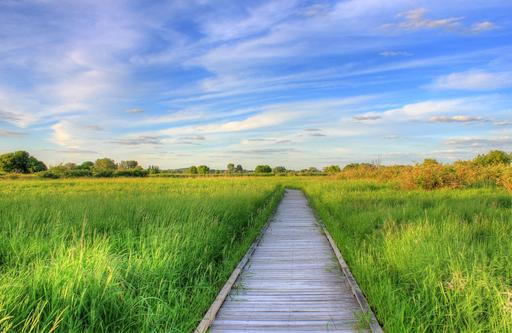


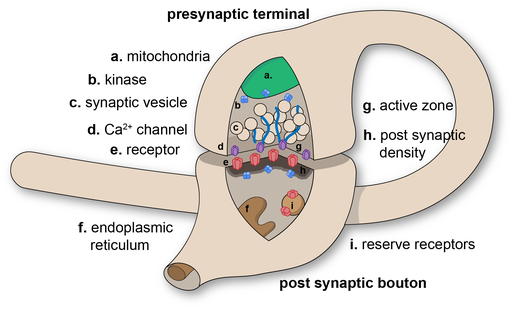


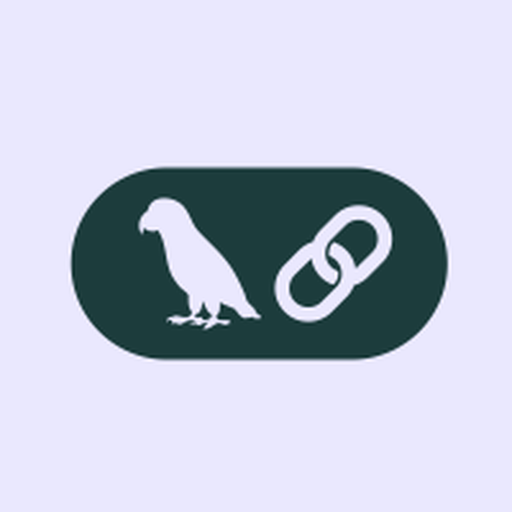

('It seems you\'re trying to make connections between seemingly unrelated images!  While I can\'t infer your thought process, I can offer some observations about each image:\n\n* **Image 1: The Path Through Nature.** This serene photo evokes a sense of peace and the vastness of the natural world. If we were to relate this to the universe, the path could symbolize our journey of discovery through the cosmos. Each step we take, like new scientific discoveries, reveals more of the universe\'s beauty and complexity. \n\n* **Image 2: The Synapse.** This diagram illustrates the microscopic world of a synapse, the junction between two nerve cells. It\'s a reminder that even within our own bodies, there exist incredibly complex universes of activity.  We could draw a parallel to the vast networks of galaxies, each a universe unto itself, connected by gravity in a way similar to how neurons connect and communicate through synapses.\n\n* **Image 3:  Parrot and Link.** This abstract image seems t

In [ ]:
from chain import display_images, get_answer


get_answer(
    input={
        "text": input_text,
        "files": [
            {"url": image_url},
            {"url": image_url2},
            {"path": image_path},
        ],
    },
    system_prompt=system_prompt,
    model_provider="Google",
    model_name="gemini-1.5-pro",
)